In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm

mpl.rcdefaults()
mpl_config = pd.read_csv('mpl_config.csv').to_dict(orient='records')[0]
mpl.rcParams.update(mpl_config)

## Data import

In [ ]:
# Pour directement importer les bonnes sessions
sheet_name = "HERCULE"  # Nom de la feuille
headstage = 0

sheet_id = "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

filtered_sessions = df[(df['use'] == 'yes') &(df['type'].isin(['playback_block', 'playback']))]    # dans 'type' tu mets le style de sessions que tu veux regarder parmi : 'playback' et 'playback_block'
#filtered_sessions = df[(df['use'] == 'yes') &(df['type'].isin(['playback']))] 
sessions = filtered_sessions['session']
sessions_type = filtered_sessions['type']

In [621]:
def compare_diff(x):
    """
    Given a 1D array x, return an array y of same length with:
        y[i] =  1 if x[i] > x[i-1]
        y[i] = -1 if x[i] < x[i-1]
        y[i] =  0 if x[i] == x[i-1]
    y[0] is set to 0 by convention.
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=int)
    diff = np.diff(x)
    
    y[1:] = np.where(diff > 0, 1, np.where(diff < 0, -1, 0))
    
    return y

os.chdir('/Volumes/LaCie')

files_hercule =['HERCULE_20250528_SESSION_01/headstage_0/','HERCULE_20250602_SESSION_00/headstage_0/',\
       'HERCULE_20250603_SESSION_01/headstage_0/','HERCULE_20250604_SESSION_00/headstage_0/',\
      'HERCULE_20250604_SESSION_01/headstage_0/','HERCULE_20250605_SESSION_00/headstage_0/',\
      'HERCULE_20250605_SESSION_01/headstage_0/','HERCULE_20250606_SESSION_00/headstage_0/',\
      'HERCULE_20250612_SESSION_00/headstage_0/',\
      'HERCULE_20250612_SESSION_02/headstage_0/','HERCULE_20250616_SESSION_01/headstage_0/']


for i in range(len(files_hercule)) :
    files_hercule[i]='HERCULE/' + files_hercule[i]

files_napoleon  = [f for f in os.listdir('NAPOLEON/')]
for i in range(len(files_napoleon)) :
    files_napoleon[i]='NAPOLEON/' + files_napoleon[i] + '/headstage_1/'
    
files = files_hercule + files_napoleon


n_data_s = []
f_data_s = []
for file in tqdm(files) :
    try :
        n_data = np.load(file+'data_0.005.npy')
        f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
        gc = np.load(file+'good_clusters.npy')
        
        
        f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}
    
        for item in f_data:
            for key, value in item.items():
                f_data_dict[key].append(value)

        f_data = pd.DataFrame(f_data_dict)
        f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
        f_data['Mock_direction'] = compare_diff(f_data['Mock_frequency'].to_numpy())
        
        n_data = n_data[gc,:].astype(float)
        #n_data=n_data.astype(float)
    
        n_data_s.append(n_data)
        f_data_s.append(f_data)
        
    except :
        print('Error when building dataframe for file :' + str(file))

os.chdir('/Users/hugot/Documents/PHD/Felicie')

  0%|          | 0/49 [00:00<?, ?it/s]

Error when building dataframe for file :NAPOLEON/NAPOLEON_20241202_SESSION_02/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241212_SESSION_02/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241213_SESSION_01/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241220_SESSION_01/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250127_SESSION_00/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250217_SESSION_00/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250217_SESSION_01/headstage_1/


In [622]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_s))) :
    n_data_smooth = gaussian_filter(n_data_s[i],sigma=10,axes=1)
    n_data_s[i] = n_data_smooth

  0%|          | 0/42 [00:00<?, ?it/s]

In [841]:
with open("Save/hercule_a1", "wb") as fp:   #Pickling
    pickle.dump(n_data_s[:len(files_hercule)], fp)

with open("Save/napoleon_a1", "wb") as fp: 
    pickle.dump(n_data_s[len(files_hercule):], fp)

with open("Save/hercule_features", "wb") as fp:
    pickle.dump(f_data_s[:len(files_hercule)], fp)

with open("Save/napoleon_features", "wb") as fp:
    pickle.dump(f_data_s[len(files_hercule):], fp)

with open("Save/h&n_a1", "wb") as fp:
    pickle.dump(n_data_s, fp)

with open("Save/h&n_features", "wb") as fp:
    pickle.dump(f_data_s, fp)

In [2]:
with open("Save/h&n_a1", "rb") as fp:
    n_data_s = pickle.load(fp)

with open("Save/h&n_features", "rb") as fp:
    f_data_s = pickle.load(fp)

## Analysis A1

In [3]:
w_size = 100
def get_event_vicinity(bool_array, window_size=100):
    """
    Return a 2D array of indices around True values in a boolean array,
    skipping events that overlap more than 50% with previous ones.

    Parameters:
        bool_array (np.ndarray): 1D boolean array.
        window_size (int): Number of indices before and after each True value.

    Returns:
        np.ndarray: 2D array of index windows, one per event.
    """
    event_indices = np.where(bool_array)[0]
    total_len = len(bool_array)
    full_window_size = window_size 
    last_window_end = -np.inf
    result = []

    for idx in event_indices:
        start = max(0, idx - int(window_size/3))
        end = min(total_len, idx + int(2*window_size/3)+ 1)
        indices = np.arange(start, end)

        # Pad if at edge
        if len(indices) < window_size:
            pad_len = full_window_size - len(indices)
            indices = np.pad(indices, (0, pad_len), mode='constant', constant_values=-1)

        # Check for overlap with previous event
        if start < last_window_end:
            overlap = last_window_end - start
            if overlap > 0: # window_size//5:
                continue  # Too much overlap, skip this event

        result.append(indices)
        last_window_end = end  # update end of last accepted window

    return np.array(result)

def compute_mean_trajectories(trajectories, vicinity_indices, event_values):
    """
    Computes the mean trajectory in the vicinity of events grouped by event label.

    Parameters:
        trajectories (np.ndarray): [T, D] array of trajectory over time.
        vicinity_indices (np.ndarray): [N_events, window_size] of indices for each event.
        event_values (np.ndarray): [N_events] of numerical event labels (can be float or int).

    Returns:
        dict: {label: mean_trajectory} where mean_trajectory is [window_size, D]
    """
    unique_labels = np.unique(event_values)
    result = {}

    for label in unique_labels:
        # Find all events with this label
        label_mask = event_values == label
        label_indices = vicinity_indices[label_mask]

        valid_segments = []
        for inds in label_indices:
            # Filter out -1 (padding from earlier step)
            valid_mask = inds >= 0
            if np.any(valid_mask):
                valid_inds = inds[valid_mask]
                segment = trajectories[valid_inds]
                # Pad with NaNs if needed (for edge events)
                if segment.shape[0] < inds.shape[0]:
                    padded = np.full((inds.shape[0], trajectories.shape[1]), np.nan)
                    padded[valid_mask] = segment
                    segment = padded
                valid_segments.append(segment)

        if valid_segments:
            mean_traj = np.nanmean(np.stack(valid_segments), axis=0)
            result[label] = mean_traj

    return result

In [4]:
f_min, f_max = 1000, 5000
all_traj_track_p, all_traj_track_m = [], []
all_traj_pb_p, all_traj_pb_m, all_traj_pb_mock = [], [], []

def process_traj(data, event_idx, event_freq):
    """Compute and filter mean trajectories by frequency range."""
    m_traj = compute_mean_trajectories(data.T, event_idx, event_freq)
    return {k: v for k, v in m_traj.items() if f_min <= k <= f_max}

for n_data, f_data in zip(n_data_s, f_data_s):
    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    mock = f_data['Mock_frequency'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    triggers_mock = f_data['Mock_change'].to_numpy()
    condition = f_data['Condition'].to_numpy()

    trigger_map = {
        'track_p': triggers * (condition == 0) * (direc == 1),
        'track_m': triggers * (condition == 0) * (direc == -1),
        'pb_p':    triggers * (condition == 1) * (direc == 1),
        'pb_m':    triggers * (condition == 1) * (direc == -1),
        'pb_mock': triggers_mock * (condition == 1),
    }

    event_idx_map = {k: get_event_vicinity(v, w_size) for k, v in trigger_map.items()}
    freq_map = {
        'track_p': freq[event_idx_map['track_p'][:, w_size - 1]],
        'track_m': freq[event_idx_map['track_m'][:, w_size - 1]],
        'pb_p':    freq[event_idx_map['pb_p'][:, w_size - 1]],
        'pb_m':    freq[event_idx_map['pb_m'][:, w_size - 1]],
        'pb_mock': mock[event_idx_map['pb_mock'][:, w_size - 1]],
    }

    all_traj_track_p.append(process_traj(n_data, event_idx_map['track_p'], freq_map['track_p']))
    all_traj_track_m.append(process_traj(n_data, event_idx_map['track_m'], freq_map['track_m']))
    all_traj_pb_p.append(process_traj(n_data, event_idx_map['pb_p'], freq_map['pb_p']))
    all_traj_pb_m.append(process_traj(n_data, event_idx_map['pb_m'], freq_map['pb_m']))
    all_traj_pb_mock.append(process_traj(n_data, event_idx_map['pb_mock'], freq_map['pb_mock']))


In [5]:
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = {key:[] for key in mean_traj_dicts[0].keys()}

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df


traj_df_track_p, traj_df_track_m = pseudo_trajectories(all_traj_track_p), pseudo_trajectories(all_traj_track_m)
traj_df_pb_p, traj_df_pb_m = pseudo_trajectories(all_traj_pb_p), pseudo_trajectories(all_traj_pb_m)

In [6]:
from sklearn.decomposition import PCA


def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

# Stack trajectories
traj_mats = [
    np.stack(traj_df_track_p['trajectory']),
    np.stack(traj_df_track_m['trajectory']),
    np.stack(traj_df_pb_p['trajectory']),
    np.stack(traj_df_pb_m['trajectory']),
]

# Concatenate all trajectory matrices
traj_mat_all = np.concatenate(traj_mats, axis=0)

# Flatten for PCA
n_samples, n_time, n_features = traj_mat_all.shape
traj_mat_flat = standardize(traj_mat_all.reshape(n_samples * n_time, n_features))

# PCA
n_comp = 10
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

# Reshape back to original time structure
traj_PC_all = traj_PC_all_flat.reshape(n_samples, n_time, n_comp)

# Split back into groups
nb_freq = traj_mats[0].shape[0]
traj_PC_track_p, traj_PC_track_m, traj_PC_pb_p, traj_PC_pb_m = [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats))
]


In [32]:
with open("Save/PCA_a1_1000-5000", "wb") as fp:   #Pickling
    pickle.dump(pca_all, fp)

### Visualization

In [7]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection


def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)


def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0, marker='o', lw=2, alpha=0.8, show_plane=False,plane_color='grey', plane_alpha=0.1):
    """
    Fit a smooth curve through points (2D or 3D) and color it using HSV/RGB base colors.
    Optionally show the 2D PCA plane of maximum variance in 3D case.
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N, dim = points.shape
    if dim not in (2, 3):
        raise ValueError("Points must be either 2D or 3D.")

    # Parameterize the spline by normalized arc length
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    cumulative_dist /= cumulative_dist[-1] if cumulative_dist[-1] != 0 else 1.0

    # Fit spline
    tck, u = splprep(points.T, s=smooth, k=min(3, N-1))
    u_interp = np.linspace(0, 1, n_interp)
    coords_interp = splev(u_interp, tck)
    curve_points = np.stack(coords_interp, axis=1)

    # Interpolate colors
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")
    rgb_interp = np.stack([interp_r(u_interp), interp_g(u_interp), interp_b(u_interp)], axis=1)

    # Build segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    if dim == 2:
        lc = LineCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)

    else:
        lc = Line3DCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection3d(lc)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)

        # Optionally draw 2D PCA plane
        if show_plane:
            pca = PCA(n_components=2)
            pca.fit(points)
            center = points.mean(axis=0)
            vecs = pca.components_
            # Create grid in PCA space
            grid_range = np.linspace(-1, 1, 10) * np.std(points, axis=0).max()
            Xg, Yg = np.meshgrid(grid_range, grid_range)
            plane_points = center + Xg[..., None] * vecs[0] + Yg[..., None] * vecs[1]
            ax.plot_surface(plane_points[..., 0], plane_points[..., 1], plane_points[..., 2],
                            color=plane_color, alpha=plane_alpha, linewidth=0, shade=False)


        return pca.components_

Text(0, 0.5, 'PC2')

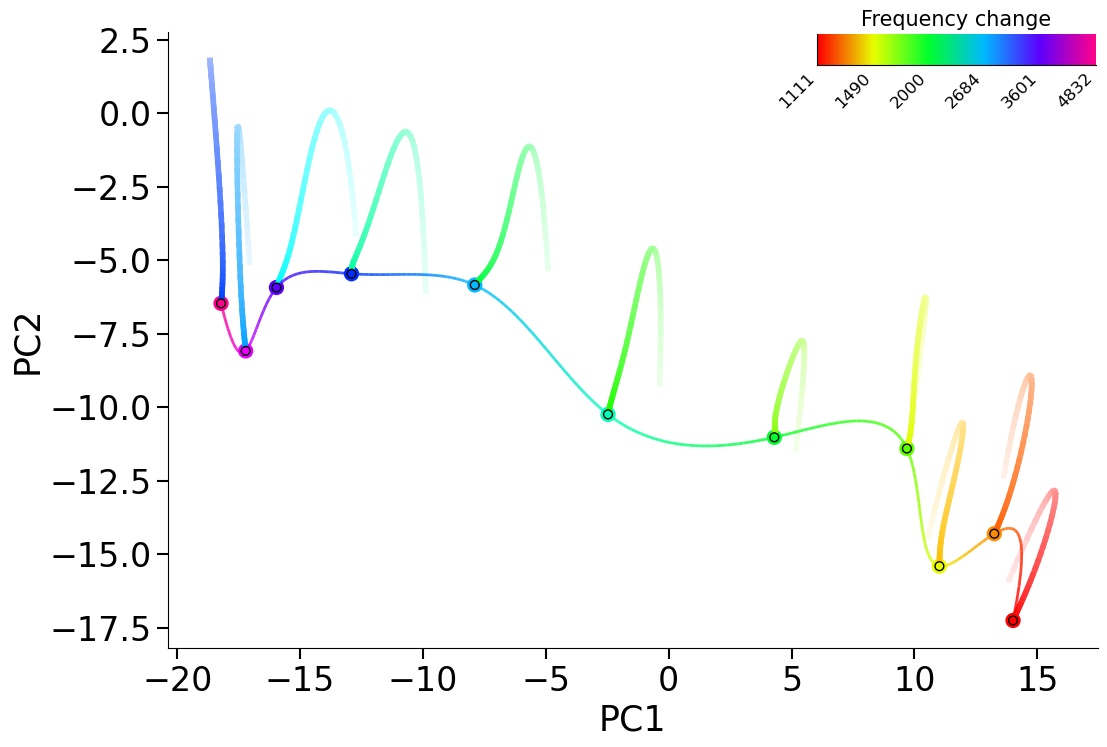

In [8]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_pb_p

nb_times = len(traj_toplot[0])

start_time = int(nb_times*0.3)
stop_time = int(nb_times*0.7)

for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][start_time:stop_time,:2],ax,cmaps[i])

    
colors = get_hsv_colors(len(traj_toplot))



ax.scatter(traj_toplot[:,stop_time,0],traj_toplot[:,stop_time,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_toplot[:,stop_time,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.savefig('Plots/SVG/tonotopy_traj_tracking_-_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_tracking_-_hstage1.PNG', dpi = 300,bbox_inches='tight')

### Comparing Tracking vs Playback representations

Text(0, 0.5, 'PC2')

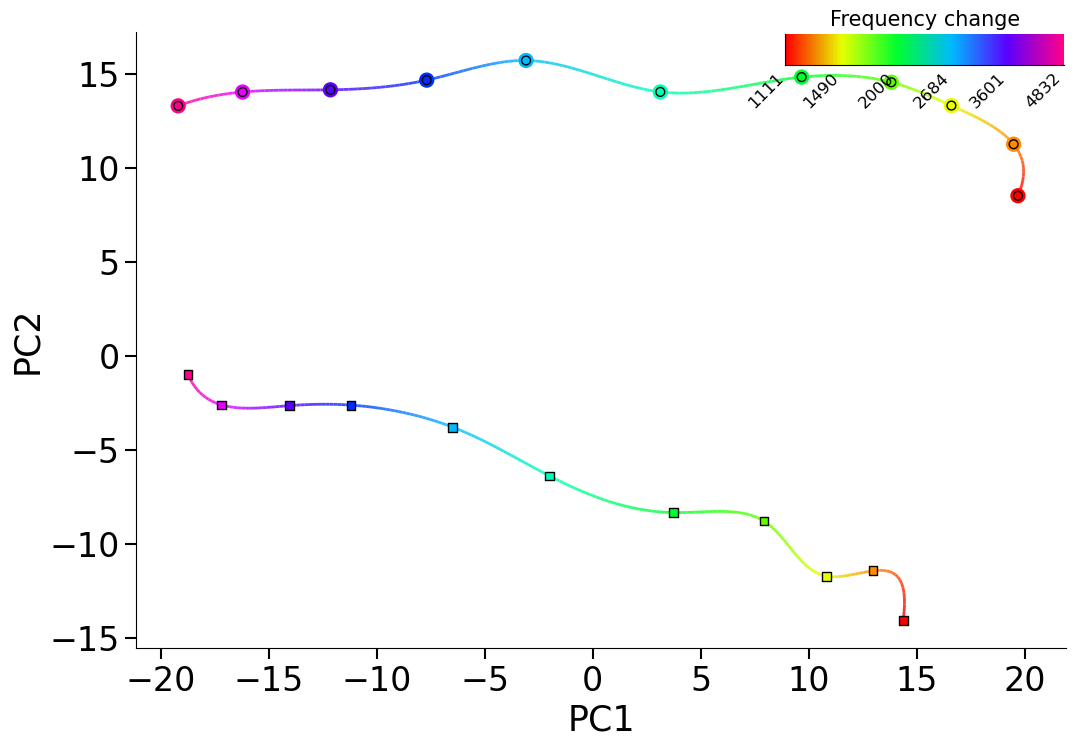

In [9]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_pb = (traj_PC_pb_p + traj_PC_pb_m)/2
traj_track = (traj_PC_track_p + traj_PC_track_m)/2
"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][:,:2],ax,cmaps[i])
"""
colors = get_hsv_colors(len(traj_pb))
nb_times = len(traj_pb[0])

ax.scatter(traj_track[:,nb_times//3,0],traj_track[:,nb_times//3,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_track[:,nb_times//3,:2],colors, ax)

plot_gradient_curve(traj_pb[:,nb_times//3,:2],colors, ax, marker='s')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

In [54]:
with open("Save/CCA_a1_1000-5000_pb", "rb") as fp:   # Unpickling
     cca_a1 = pickle.load(fp)

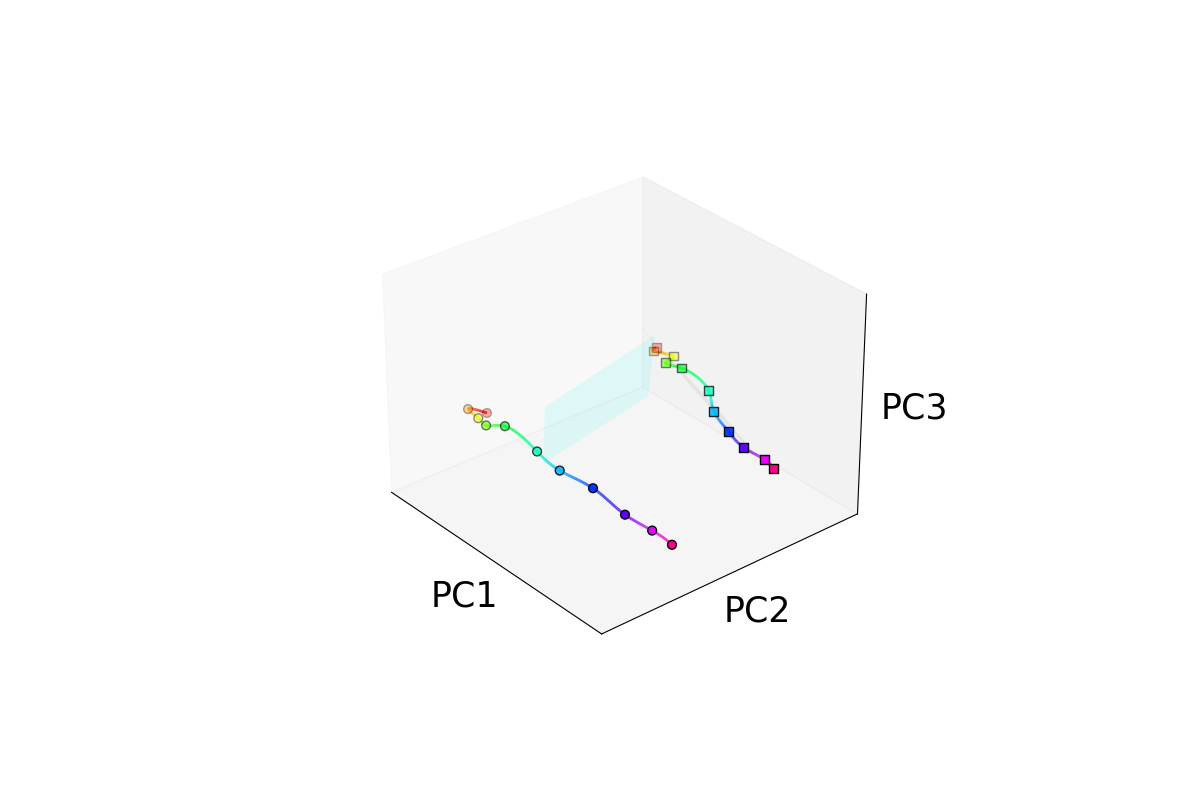

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib widget

def plot_plane(ax, B, center=None, size=1.0, alpha=0.2, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    # Define corners of the plane
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    # Create the polygon
    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)


cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(11)

traj_PC_track = (traj_PC_track_p + traj_PC_track_m)/2
traj_PC_pb = (traj_PC_pb_p + traj_PC_pb_m)/2

comps=[0,1,2]

#ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,stop_time,1],traj_PC_track[:,stop_time,2],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,stop_time,1],traj_PC_pb[:,stop_time,2],c=colors,s=100)
plane_track = plot_gradient_curve(traj_PC_track[:,10,comps],colors, ax,show_plane=True)
plane_pb = plot_gradient_curve(traj_PC_pb[:,10,comps],colors, ax,marker='s',show_plane=True)

plot_plane(ax, cca_a1[comps,:][:,[0,1]], size=20, alpha=0.1, color='cyan')


ax.set_xlabel('PC'+ str(comps[0]+1))
ax.set_ylabel('PC'+ str(comps[1]+1))
ax.set_zlabel('PC'+ str(comps[2]+1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=140, elev=30)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

In [ ]:
mpl.pyplot.close()

In [138]:
def vec_alignement(n1,n2) :
    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)
    
    # Dot product clipped to [-1, 1] for numerical safety
    dot = np.clip(np.dot(n1, n2), -1.0, 1.0)
    
    theta = np.arccos(dot)
    theta = min(theta, np.pi - theta)

    return theta*180/np.pi


pca_2d_track = PCA(n_components=2)
pca_2d_pb = PCA(n_components=2)

comps = [[i,i+1,i+2] for i in range(np.shape(traj_PC_track)[2]-2)]

n_freq = len(traj_PC_track)

tonotopy_alignement_pc = []
for comp in comps:
    align_boot = []
    for b in range(100) :
        track_boot = traj_PC_track[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comp]
        pb_boot = traj_PC_pb[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comp]
        
        pca_2d_track.fit(track_boot)
        pca_2d_pb.fit(pb_boot)
    
        n1 = np.cross(pca_2d_track.components_[0], pca_2d_track.components_[1])
        n2 = np.cross(pca_2d_pb.components_[0], pca_2d_pb.components_[1])
        
        align_boot.append(vec_alignement(n1,n2))

    tonotopy_alignement_pc.append(align_boot)

alignement_permu = [vec_alignement(np.random.normal(size = 3),np.random.normal(size = 3)) for _ in range(1000)]

tonotopy_alignement_pc = np.array(tonotopy_alignement_pc)

[27.6449307  84.33144379]


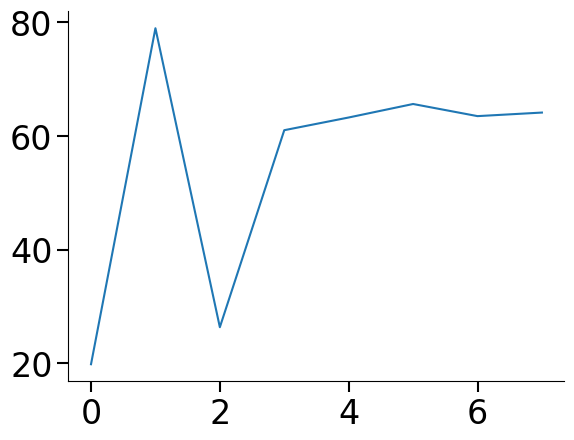

In [160]:
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(np.mean(tonotopy_alignement_pc,axis=1),sigma=0))
print(np.percentile(alignement_permu,(10,90)))

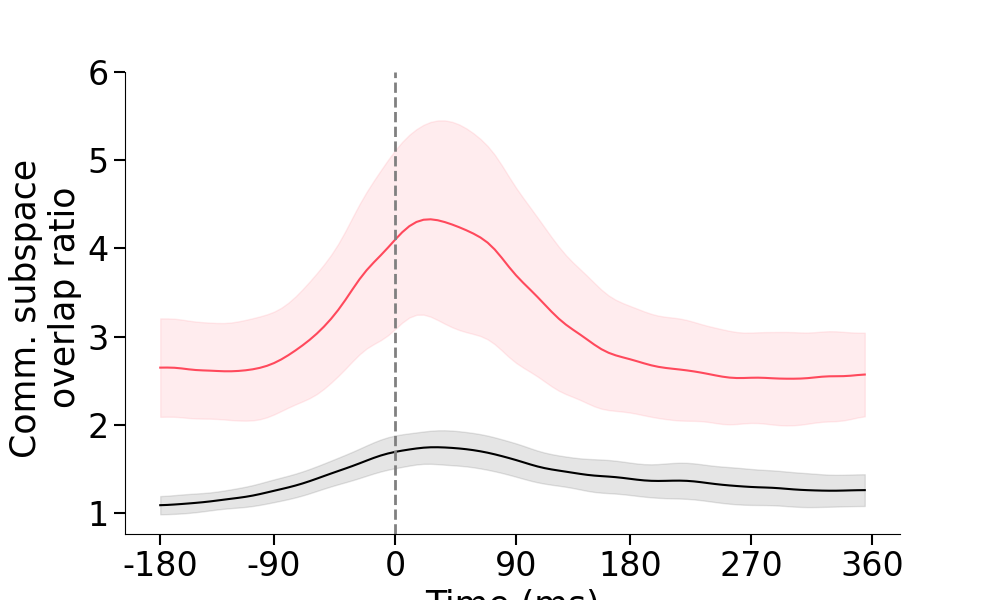

In [105]:
from scipy.ndimage import gaussian_filter

def variance_explained_by_subspace(W, X):
    """
    Compute variance explained by a subspace and its orthogonal complement.

    Parameters
    ----------
    W : ndarray, shape (n_features, n_components)
        CCA weight matrix (columns are subspace basis vectors).
    X : ndarray, shape (n_samples, n_features)
        Data matrix.

    Returns
    -------
    var_in_subspace : float
        Fraction of total variance explained by the CCA subspace.
    var_in_complement : float
        Fraction of total variance in the orthogonal complement.
    """
    Q, _ = np.linalg.qr(W)  # Q spans the same subspace as W

    # Project data into subspace
    X_proj = X @ Q @ Q.T   

    # Residual (orthogonal complement)
    X_resid = X - X_proj

    # Total variance
    total_var = np.sum(np.var(X, axis=0, ddof=1))

    # Variance in subspace
    var_subspace = np.sum(np.var(X_proj, axis=0, ddof=1))
    var_complement = np.sum(np.var(X_resid, axis=0, ddof=1))

    return (var_subspace / total_var) / (var_complement / total_var)



var_com_track = np.array([[variance_explained_by_subspace(cca_a1[:,:5],traj_PC_track[np.random.choice(range(len(traj_PC_track)),len(traj_PC_track)),t,:])\
                           for _ in range(100)] for t in range(np.shape(traj_PC_track)[1])])

var_com_pb = np.array([[variance_explained_by_subspace(cca_a1[:,:5],traj_PC_pb[np.random.choice(range(len(traj_PC_pb)),len(traj_PC_pb)),t,:])\
                           for _ in range(100)] for t in range(np.shape(traj_PC_pb)[1])])


track_CI_up, track_CI_down = np.mean(var_com_track,axis=1) + np.std(var_com_track,axis=1), np.mean(var_com_track,axis=1) - np.std(var_com_track,axis=1)
pb_CI_up, pb_CI_down = np.mean(var_com_pb,axis=1) + np.std(var_com_pb,axis=1), np.mean(var_com_pb,axis=1) - np.std(var_com_pb,axis=1)

fig = plt.figure(figsize=(10,6))

sgm=2
plt.plot(gaussian_filter(np.mean(var_com_track,axis=1),sigma=sgm),color='#FF495C')
plt.plot(gaussian_filter(np.mean(var_com_pb,axis=1),sigma=sgm),color='black')

plt.fill_between(range(len(var_com_track)),gaussian_filter(track_CI_down,sigma=sgm),gaussian_filter(track_CI_up,sigma=sgm),color='#FF495C',alpha=0.1)
plt.fill_between(range(len(var_com_pb)),gaussian_filter(pb_CI_down,sigma=sgm),gaussian_filter(pb_CI_up,sigma=sgm),color='black',alpha=0.1)
plt.axvline(33, linestyle='--',color='grey',linewidth=2)

plt.ylabel('Comm. subspace \n overlap ratio')
plt.xlabel('Time (ms)')
plt.yticks([1,2,3,4,5,6])
plt.xticks([0,16,33,50,66,83,100],[-180,-90,0,90,180,270,360])

plt.savefig('Plots/SVG/overlap_ratio.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/overlap_ratio.PNG', dpi = 300,bbox_inches='tight')

In [131]:
def vec_alignement(n1,n2) :
    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)
    
    # Dot product clipped to [-1, 1] for numerical safety
    dot = np.clip(np.dot(n1, n2), -1.0, 1.0)
    
    theta = np.arccos(dot)
    theta = min(theta, np.pi - theta)

    return theta*180/np.pi


pca_2d_track = PCA(n_components=2)
pca_2d_pb = PCA(n_components=2)

comps = [0,1,2]

n_freq = len(traj_PC_track)

tonotopy_alignement = []
ctx_n1 = []
ctx_n2 = []
for b in range(100) :
    track_boot = traj_PC_track[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comps]
    pb_boot = traj_PC_pb[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comps]
    
    pca_2d_track.fit(track_boot)
    pca_2d_pb.fit(pb_boot)

    ctx_axis = np.mean(track_boot,axis=0) - np.mean(pb_boot,axis=0)

    n1 = np.cross(pca_2d_track.components_[0], pca_2d_track.components_[1])
    n2 = np.cross(pca_2d_pb.components_[0], pca_2d_pb.components_[1])
    
    tonotopy_alignement.append(vec_alignement(n1,n2))
    ctx_n1.append(vec_alignement(n1,ctx_axis))
    ctx_n2.append(vec_alignement(n2,ctx_axis))

alignement_permu = [vec_alignement(np.random.normal(size = 3),np.random.normal(size = 3)) for _ in range(1000)]

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/3306040458.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Value", y="Group", ax=ax, width=0.6, palette=palette,linecolor='black',


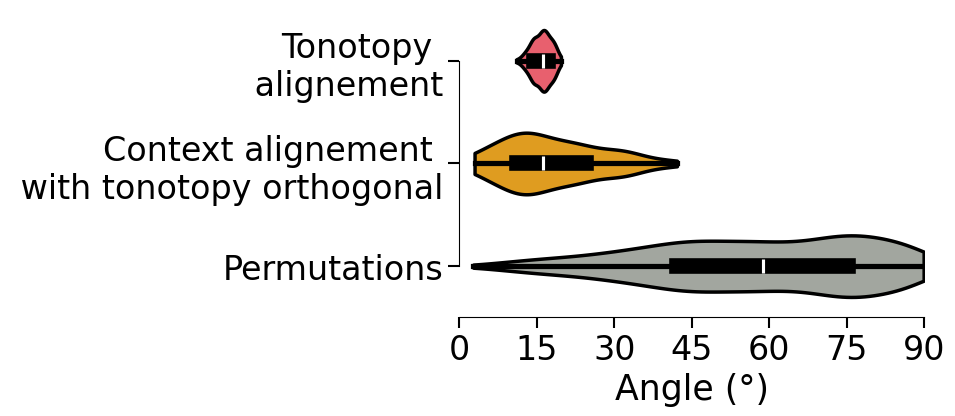

In [535]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def violinplots(data_list, y_labels=("Tonotopy \n alignement","Context alignement \n with tonotopy orthogonal", "Permutations"),
                         x_label="Angle (°)", palette=("#FF495C", 'orange',"#A2A79E"),
                         figsize=(6,4)):

    # Tidy DataFrame for seaborn
    vals = np.concatenate([np.asarray(list_i, float) for list_i in data_list])
    groups = np.repeat(y_labels, [len(list_i) for list_i in data_list])
    df = pd.DataFrame({"Group": groups, "Value": vals})

    fig, ax = plt.subplots(figsize=figsize)

    # Notched (“conic”) boxplots
    sns.violinplot(data=df, x="Value", y="Group", ax=ax, width=0.6, palette=palette,linecolor='black',
                linewidth=2.5,cut=0,inner="box",bw_adjust=1,orient='h')

    # Labels and cosmetics
    ax.set_xlabel(x_label)
    ax.set_xlim(0, 90)
    ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
    ax.set_ylabel("")
    sns.despine(ax=ax, trim=True)
    
    return fig, ax

violinplots([tonotopy_alignement,ctx_n2,alignement_permu])
ax.set_xlim(0, 90)

plt.savefig('Plots/SVG/tonotopy_geometry.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/tonotopy_geometry.PNG', dpi = 300,bbox_inches='tight')

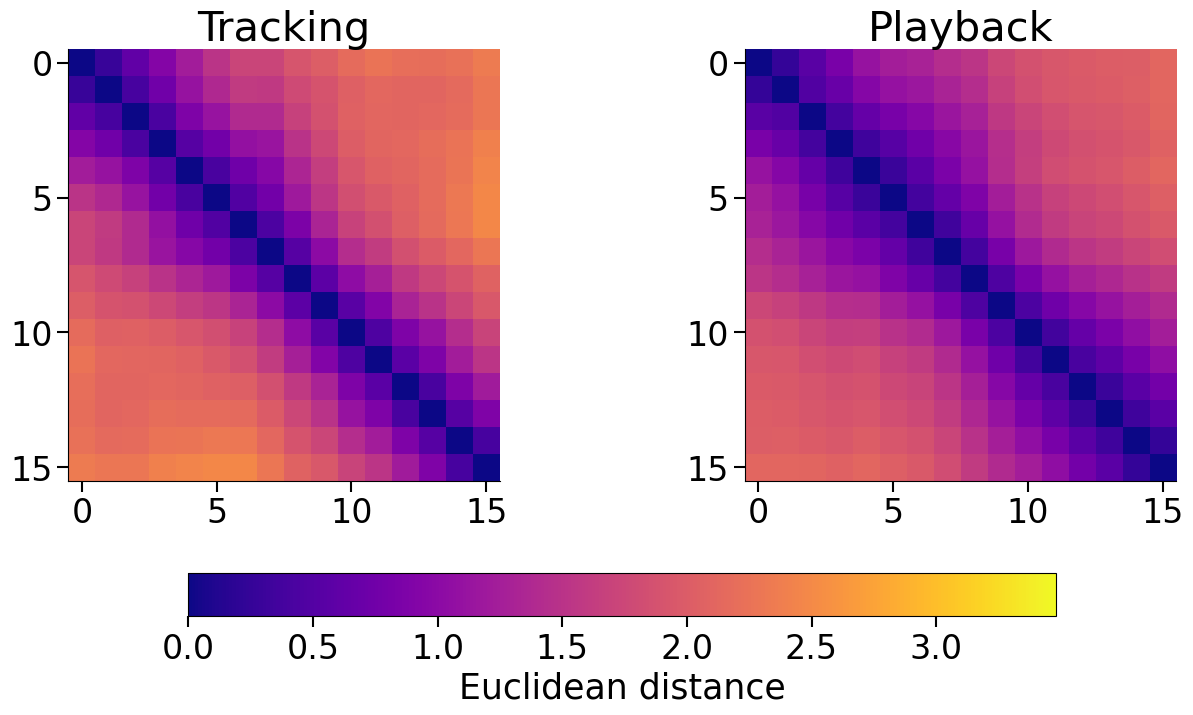

In [404]:
def pairwise_distance(X):
    "X is n_sample times n_features"
    diff = X[:, None, :] - X[None, :, :] 
    D = np.sqrt(np.sum(diff ** 2, axis=-1))
    return D

# --- distance matrices ---
D_track = pairwise_distance(traj_PC_track[:, -1, :])
D_pb    = pairwise_distance(traj_PC_pb[:,   -1, :])

# global colour scale: min & max across BOTH matrices
vmin, vmax = np.min([D_track.min(), D_pb.min()]), np.max([D_track.max(), D_pb.max()])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax+1)   # shared normalisation

# --- plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

im0 = axs[0].imshow(D_track, norm=norm, cmap='plasma')
im1 = axs[1].imshow(D_pb,    norm=norm, cmap='plasma')

axs[0].set_title('Tracking')
axs[1].set_title('Playback')

# single colour-bar for both panels
fig.colorbar(im0, ax=axs.ravel().tolist(), shrink=0.7,orientation='horizontal', location='bottom',label='Euclidean distance')

plt.show()

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/991154088.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Condition', y='Distance',


<Axes: ylabel='Pairwise distance'>

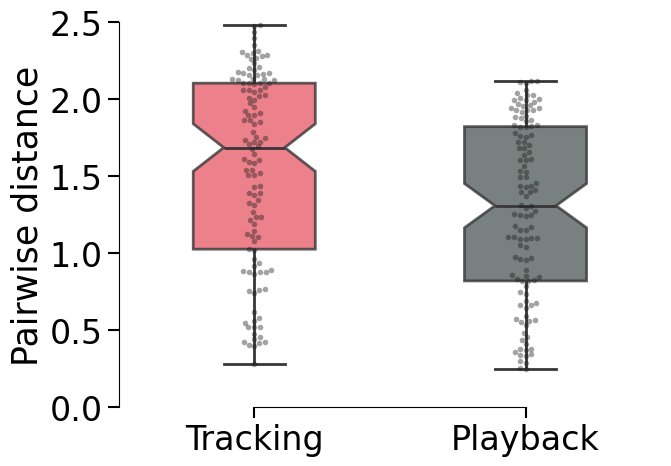

In [872]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_upper_triangles(D1, D2,
                             labels=("Matrix 1", "Matrix 2"),
                             palette=('#FF495C', '#546460'),
                             swarm_alpha=.4,
                             ax=None):
    """
    Prettier comparison of the upper-triangle coefficients of two
    distance matrices: notched box + swarm overlay.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # ---------- extract upper triangles ----------
    iu = np.triu_indices_from(D1, k=1)
    vals1, vals2 = D1[iu], D2[iu]

    # ---------- tidy DataFrame for seaborn ----------
    df = (pd.DataFrame({
            'Condition': np.repeat(labels, [len(vals1), len(vals2)]),
            'Distance':  np.concatenate([vals1, vals2])
          })
          .reset_index(drop=True))

    # ---------- figure / axes ----------
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # ---------- style ----------
    #sns.set_theme(style="whitegrid", font_scale=1.2)
    #sns.set_theme() 
    sns.boxplot(data=df, x='Condition', y='Distance',
                palette=palette,
                width=.45,
                notch=True,
                linewidth=2,
                fliersize=0,                # hide default outliers
                boxprops=dict(alpha=.8))
    sns.swarmplot(data=df, x='Condition', y='Distance',
                  color='k', alpha=swarm_alpha, size=4)

    # ---------- axes extras ----------
    ax.set_ylabel("Pairwise distance")
    ax.set_xlabel("")
    ax.set_ylim(0, 2.5)
    sns.despine(trim=True)
    return ax

boxplot_upper_triangles(D_track, D_pb, labels=("Tracking", "Playback"))

#plt.savefig('Plots/SVG/dist_tonotopy.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/dist_tonotopy.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
iu = np.triu_indices_from(D_track, k=1)
vals1, vals2 = D_track[iu], D_pb[iu]

mannwhitneyu(vals1,vals2)

### Frequency change decoding

In [5]:
np.random.seed(42)

w_size_decoding = 100
n_samples = 300
Xs, Ys = [], []

def sample_events(n_data, triggers, freq, n_samples, w_size):
    """Get sampled event indices, frequencies, and stacked neural data."""
    event_idx = get_event_vicinity(triggers, w_size)
    sampled_idx = np.random.choice(len(event_idx), n_samples, replace=False)
    event_idx = event_idx[sampled_idx]
    event_freq = freq[event_idx[:, 0]]  #Set 0 to have starting frequency
    stacked_data = np.stack([n_data[:, idx] for idx in event_idx])
    return event_freq, stacked_data

for n_data, f_data in zip(n_data_s, f_data_s):
    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    condition = f_data['Condition'].to_numpy()

    trigger_map = {
        ('track', +1): triggers * (condition == 0) * (direc == 1),
        ('track', -1): triggers * (condition == 0) * (direc == -1),
        ('pb',    +1): triggers * (condition == 1) * (direc == 1),
        ('pb',    -1): triggers * (condition == 1) * (direc == -1),
    }

    freqs, data_blocks = [], []
    for (cond, change), trig in trigger_map.items():
        f, d = sample_events(n_data, trig, freq, n_samples, w_size_decoding)
        freqs.append(f)
        data_blocks.append(d)

    # Concatenate data
    Xs.append(np.concatenate(data_blocks, axis=0))

    # Labels
    freq_label = np.concatenate(freqs)
    cond_label = np.concatenate([
        np.full(n_samples * 2, 0),  # track
        np.full(n_samples * 2, 1)   # pb
    ])
    change_label = np.concatenate([
        np.full(n_samples, +1), np.full(n_samples, -1),  # track
        np.full(n_samples, +1), np.full(n_samples, -1)   # pb
    ])
    Ys.append(np.stack((freq_label, change_label, cond_label), axis=1))

X = np.concatenate(Xs, axis=1)
Y = Ys[0]


In [37]:
X.shape

(1200, 755, 100)

In [10]:
with open("Save/PCA_a1_widefreq", "rb") as fp:   # Unpickling
     pca_a1 = pickle.load(fp)

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold

def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

def fit_C(X, y):
    """Select best C using cross-validation."""
    candidate_c = np.logspace(-2, 2, num=15)
    rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=77)
    scores = []
    for c in candidate_c:
        fold_scores = []
        for tr_idx, te_idx in rkf.split(X):
            model = SVC(C=c, kernel='linear')
            model.fit(X[tr_idx], y[tr_idx])
            fold_scores.append(model.score(X[te_idx], y[te_idx]))
        scores.append(np.mean(fold_scores))
    return candidate_c[np.argmax(scores)]

def decode_condition(X_cond, y_cond, pca_all, timestep, t, nb_permu):
    """Train/test SVC for one condition & timepoint with permutation correction."""
    # Prepare data
    X_win = np.mean(X_cond[:, :, t*timestep:(t+1)*timestep], axis=-1)
    X_win = standardize(pca_all.transform(X_win))
    y_target = y_cond[:, 1]  # change label

    # Select best C
    c_best = fit_C(X_win, y_target)

    rkf = RepeatedKFold(n_splits=2, n_repeats=5, random_state=42)
    scores = []
    for tr_idx, te_idx in rkf.split(X_win):
        X_tr, X_te = X_win[tr_idx], X_win[te_idx]
        y_tr, y_te = y_target[tr_idx], y_target[te_idx]

        model = SVC(C=c_best, kernel='linear')
        model.fit(X_tr, y_tr)
        score = model.score(X_te, y_te)

        # Permutation correction
        perm_scores = []
        for _ in range(nb_permu):
            np.random.shuffle(X_tr)
            perm_model = SVC(C=c_best, kernel='linear')
            perm_model.fit(X_tr, y_tr)
            perm_scores.append(perm_model.score(X_te, y_te))

        scores.append(score - np.nanmedian(perm_scores))
    return np.mean(scores)

# ---------------- Main loop ----------------
nb_permu = 10
nb_bootstrap = 20
timestep = 4

track_change_decoding = []
pb_change_decoding = []

for b in tqdm(range(nb_bootstrap)):
    boot_idx = np.random.choice(len(X), len(X), replace=True)
    X_b, Y_b = X[boot_idx], Y[boot_idx]

    track_scores_t = []
    pb_scores_t = []
    n_time_bins = X.shape[-1] // timestep

    for t in range(n_time_bins):
        # Masks
        track_mask = (Y_b[:, 2] == 0) & (1200 <= Y_b[:, 0]) & (Y_b[:, 0] <= 5000)
        pb_mask    = (Y_b[:, 2] == 1) & (1200 <= Y_b[:, 0]) & (Y_b[:, 0] <= 5000)

        track_scores_t.append(decode_condition(X_b[track_mask], Y_b[track_mask], pca_all, timestep, t, nb_permu))
        pb_scores_t.append(decode_condition(X_b[pb_mask],    Y_b[pb_mask],    pca_all, timestep, t, nb_permu))

    track_change_decoding.append(track_scores_t)
    pb_change_decoding.append(pb_scores_t)

track_change_decoding = np.array(track_change_decoding)
pb_change_decoding = np.array(pb_change_decoding)


  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'pca_all' is not defined

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

timestep = 4

def fit_alpha_ridge(X, y):
    """Select best alpha for Ridge regression via cross-validation."""
    alphas = np.logspace(-2, 2, num=15)
    rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=77)
    scores = []
    
    for alpha in alphas:
        fold_scores = []
        for train_idx, test_idx in rkf.split(X):
            model = Ridge(alpha=alpha)
            model.fit(X[train_idx], y[train_idx])
            fold_scores.append(model.score(X[test_idx], y[test_idx]))  # R² score
        scores.append(np.mean(fold_scores))
    
    return alphas[np.argmax(scores)], np.max(scores)  # best alpha and its score

def ridge_encoding_over_time(X_cond, y_target, timestep=timestep, pca=None):
    """
    For each time bin, fit ridge regression to predict y_cond[:,0] from X_cond.
    Return encoding axes and cross-validated scores per bin.
    
    X_cond: (n_trials, n_neurons, n_time)
    y_cond: (n_trials, n_labels)
    timestep: int, number of timepoints per bin
    pca: optional fitted PCA object to transform X_win
    """
    n_bins = X_cond.shape[-1] // timestep
    encoding_axes = []
    cv_scores = []

    mask = (1500 <= y_target[:, 0]) & (y_target[:, 0] <= 4000)
    y_target = y_target[mask,:]
    X_cond = X_cond[mask] 

    for t in tqdm(range(n_bins)):
        # Slice time window and average
        X_win = np.mean(X_cond[:, :, t*timestep:(t+1)*timestep], axis=-1)
        if pca is not None:
            X_win = pca.transform(X_win)
        
        # Find best alpha via CV
        best_alpha, best_score = fit_alpha_ridge(X_win,y_target)
        
        # Fit model with best alpha on full data
        model = Ridge(alpha=best_alpha)
        model.fit(X_win,y_target)
        
        # Normalize coefficients to get encoding axis
        axis = model.coef_ / np.linalg.norm(model.coef_) if np.linalg.norm(model.coef_) > 0 else model.coef_
        
        encoding_axes.append(axis)
        cv_scores.append(best_score)
    
    return encoding_axes, cv_scores

axes_t, scores_t = ridge_encoding_over_time(X,Y[:,0].reshape(-1,1), pca=pca_a1)

  0%|          | 0/25 [00:00<?, ?it/s]

In [18]:
Y[:,0].reshape(-1,1).shape

(1200, 1)

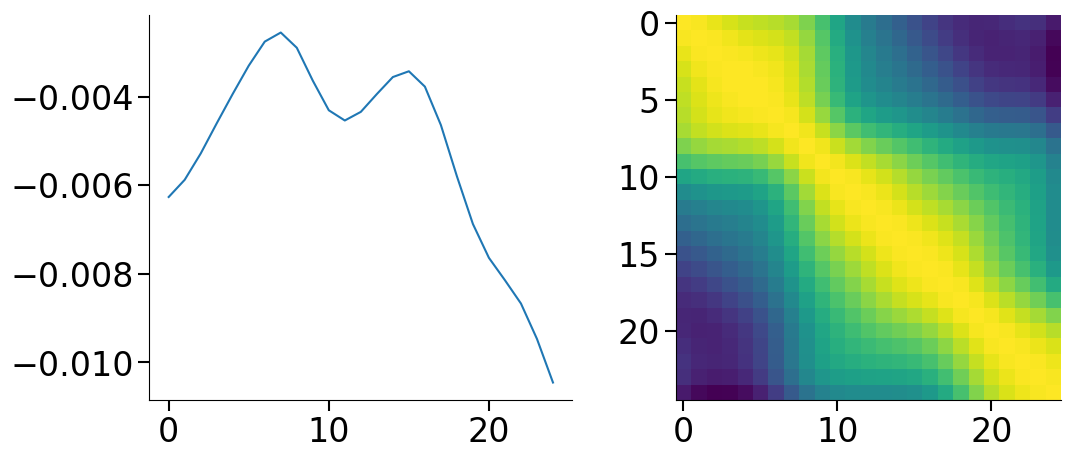

In [22]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(scores_t)
axs[1].imshow(np.corrcoef(axes_t, rowvar=True))

In [24]:
axes_t[13]

array([ 0.56597062, -0.09312443, -0.2638377 ,  0.04349456,  0.28704266,
        0.20020689, -0.49676066, -0.31138134,  0.33394401,  0.14757576])

In [ ]:
fig = plt.figure(figsize=(9,7))

"""
track_CI_up, track_CI_down = np.percentile(track_change_decoding,(95,5),axis=0)
pb_CI_up, pb_CI_down = np.percentile(pb_change_decoding,(95,5),axis=0)
diff_CI_up, diff_CI_down = np.percentile(track_change_decoding-pb_change_decoding,(95,5),axis=0)
"""

track_CI_up, track_CI_down = np.mean(track_change_decoding,axis=0) + np.std(track_change_decoding,axis=0), np.mean(track_change_decoding,axis=0) - np.std(track_change_decoding,axis=0)
pb_CI_up, pb_CI_down = np.mean(pb_change_decoding,axis=0) + np.std(pb_change_decoding,axis=0), np.mean(pb_change_decoding,axis=0) - np.std(pb_change_decoding,axis=0)
diff = track_change_decoding - pb_change_decoding
diff_CI_up, diff_CI_down = np.mean(diff,axis=0) + np.std(diff,axis=0), np.mean(diff,axis=0) - np.std(diff,axis=0)

sgm=2
plt.plot(gaussian_filter(np.mean(track_change_decoding,axis=0),sigma=sgm),color='#FF495C',linewidth=3,label='Tracking')
plt.plot(gaussian_filter(np.mean(pb_change_decoding,axis=0),sigma=sgm),color='black',linewidth=3,label='Playback')
plt.fill_between(range(w_size_decoding//timestep), gaussian_filter(track_CI_down,sigma=sgm), gaussian_filter(track_CI_up,sigma=sgm), alpha=0.05, color='#FF495C')
plt.fill_between(range(w_size_decoding//timestep), gaussian_filter(pb_CI_down,sigma=sgm), gaussian_filter(pb_CI_up,sigma=sgm), alpha=0.05, color='black')
#axs[1].plot(gaussian_filter(np.mean(track_change_decoding,axis=0) - np.mean(pb_change_decoding,axis=0),sigma=sgm),color='blue')
#axs[1].fill_between(range(w_size_decoding//timestep), gaussian_filter(diff_CI_down,sigma=sgm), gaussian_filter(diff_CI_up,sigma=sgm), alpha=0.05, color='blue')

plt.axvline(w_size_decoding//(3*timestep),linestyle='--',color='grey',linewidth=3)
#axs[1].axvline(w_size_decoding//(3*timestep),linestyle='--',color='grey')

plt.ylim(0,0.2)
plt.ylabel('Decoding of frequency change \n (above chance performance)')
plt.yticks([0,0.05,0.1,0.15,0.2],['+0% \n (chance)','+5%','+10%','+15%','+20%'])

plt.xlabel('Time from frequency change (ms)')
plt.xticks([0,w_size_decoding//(3*timestep),2*w_size_decoding//(3*timestep),w_size_decoding//timestep-1],np.array([(k-1)*w_size_decoding//(3*timestep) for k in range(4)])*5*timestep)
#axs[1].set_ylim(-0.02,0.12)
#axs[1].set_yticks([0,0.02,0.04,0.06,0.08,0.1],['0%','2%','4%','6%','8%','10%'])

plt.legend()

plt.savefig('Plots/SVG/freq_change_decoding.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/freq_change_decoding.PNG', dpi = 300,bbox_inches='tight')

In [183]:
from scipy.stats import mannwhitneyu

for t in range(np.shape(track_change_decoding)[1]) :
    print(mannwhitneyu(track_change_decoding[:,t],pb_change_decoding[:,t]))

MannwhitneyuResult(statistic=201.0, pvalue=0.9892089047911196)
MannwhitneyuResult(statistic=192.0, pvalue=0.8392322130718609)
MannwhitneyuResult(statistic=211.0, pvalue=0.7763905055505131)
MannwhitneyuResult(statistic=228.0, pvalue=0.4569506196695641)
MannwhitneyuResult(statistic=233.0, pvalue=0.379331935127312)
MannwhitneyuResult(statistic=236.0, pvalue=0.33691523838231996)
MannwhitneyuResult(statistic=284.0, pvalue=0.023903145867558408)
MannwhitneyuResult(statistic=306.0, pvalue=0.0043201840403311225)
MannwhitneyuResult(statistic=352.0, pvalue=4.1657603512605794e-05)
MannwhitneyuResult(statistic=366.0, pvalue=7.577381059726264e-06)
MannwhitneyuResult(statistic=345.0, pvalue=9.277956784594504e-05)
MannwhitneyuResult(statistic=346.0, pvalue=8.292416774489331e-05)
MannwhitneyuResult(statistic=358.0, pvalue=2.0407139096244572e-05)
MannwhitneyuResult(statistic=331.0, pvalue=0.00041550215250851585)
MannwhitneyuResult(statistic=321.0, pvalue=0.0011159472351770113)
MannwhitneyuResult(statist